In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from PIL import Image
from modules import dataset, vqvae, tools, pixelcnn

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Train the VQVAE model
### Load the data from dataset.
print the number of images in each dataset.

In [2]:
data_train, data_validate, data_test = dataset.load_data()
print(len(data_train))
print(len(data_validate))
print(len(data_test))

9664
1120
544


### Create image generator to pass to the vqvae model for training.

In [3]:
data_gen = dataset.data_generator(train_data = data_train, batch_size = 8)
validate_gen = dataset.validate_generator(validate_data = data_validate, batch_size = 8)

In [4]:
#print the output shape of the generators
img= next(data_gen)
print(img.shape)
img = next(validate_gen)
print(img.shape)

(8, 256, 256, 1)
(8, 256, 256, 1)


In [5]:
steps_per_epoch = len(data_train)/8
valiation_steps = len(data_validate)/8
print(steps_per_epoch)
print(valiation_steps)

1208.0
140.0


### Train the VQVAE model.

In [6]:
vqvae_trainer = vqvae.VQVAE(latent_dim=256, num_embeddings=256)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam())
history = vqvae_trainer.fit(data_gen, epochs = 20, validation_data = validate_gen, batch_size = 8, 
                    validation_steps = valiation_steps, validation_batch_size = 8, steps_per_epoch = steps_per_epoch)

Epoch 1/20
1208/1208 [==============================] - 64s 52ms/step - total_loss: 0.0428 - reconstruction_loss: 0.0041 - vq_loss: 0.0387 - val_total_loss: 0.0055 - val_reconstruction_loss: 0.0019 - val_vq_loss: 0.0036
Epoch 2/20
1208/1208 [==============================] - 59s 49ms/step - total_loss: 0.0045 - reconstruction_loss: 0.0016 - vq_loss: 0.0029 - val_total_loss: 0.0041 - val_reconstruction_loss: 0.0015 - val_vq_loss: 0.0027
Epoch 3/20
1208/1208 [==============================] - 60s 49ms/step - total_loss: 0.0038 - reconstruction_loss: 0.0013 - vq_loss: 0.0025 - val_total_loss: 0.0037 - val_reconstruction_loss: 0.0013 - val_vq_loss: 0.0024
Epoch 4/20
1208/1208 [==============================] - 60s 50ms/step - total_loss: 0.0034 - reconstruction_loss: 0.0012 - vq_loss: 0.0023 - val_total_loss: 0.0034 - val_reconstruction_loss: 0.0012 - val_vq_loss: 0.0023
Epoch 5/20
1208/1208 [==============================] - 60s 50ms/step - total_loss: 0.0033 - reconstruction_loss: 0.0011

Plot some results of the model (original image vs. reconstructed image outputs from the model) 

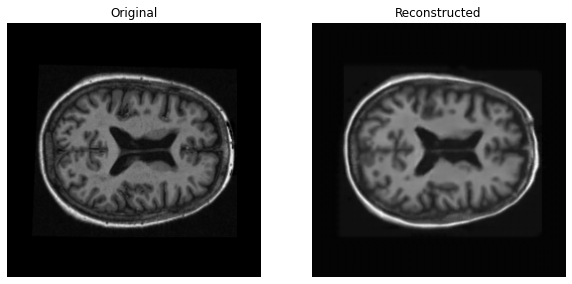

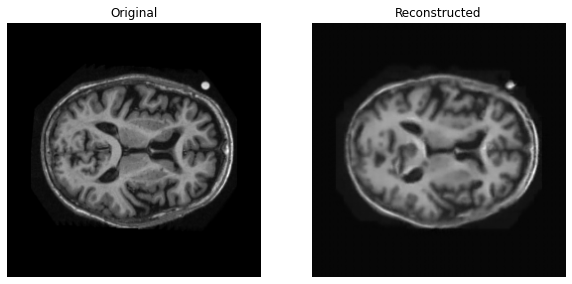

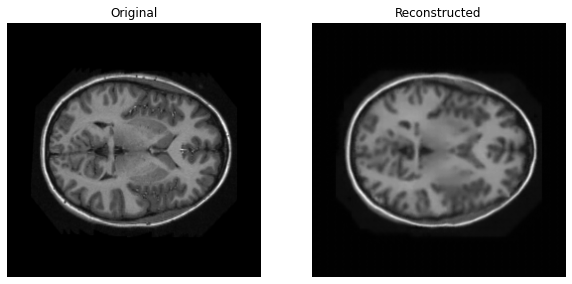

In [7]:
img_count = 3
tools.plot_images(img_count, data_test, vqvae_trainer)

### Calculate the structured similarity between the original image and the reconstructed image.
The structured similarity is 0.9886 (4 d.p.).

In [8]:
print(tools.mean_ssim(data_test, vqvae_trainer))

0.9886226580404445


# Train the PixelCNN model
### Preprocess the data to be loaded into pixelcnn.
For each image, pass it to the trained vqvae encoder and map the output from the encoder to the closest latent embedding vector in the latent space in one-hot encoded format. Since the dataset is large, it is impossible to load all the preprocessed image into the memory. Instead, I used a generator to load the images in batch size of 32.

In [9]:
train_gen = dataset.train_codebook_generator(data_train, vqvae_trainer, batch_size = 32)

data = next(train_gen)
print(data[0].shape, data[1].shape)

(32, 32, 32, 256) (32, 32, 32, 256)


In [10]:
valid_gen = dataset.validate_codebook_generator(data_validate, vqvae_trainer, batch_size = 32)

data = next(valid_gen)
print(data[0].shape, data[1].shape)

(32, 32, 32, 256) (32, 32, 32, 256)


In [11]:
#print the image shape of the encoder output(2nd,3rd element of the encoder output shape) and the number of embeddings. 
input_shape = tools.get_cnn_shape(vqvae_trainer.encoder, data_test)[1:-1]
num_embeddings = vqvae_trainer.vq_layer.num_embeddings#256
num_residual_blocks = 7
num_pixelcnn_layers = 2
print(input_shape, num_embeddings)

(32, 32) 256


In [12]:
steps_per_epoch = len(data_train)/32
valiation_steps = len(data_validate)/32
print(steps_per_epoch)
print(valiation_steps)

302.0
35.0


### Build the pixelcnn model and train it.

In [13]:
pixel_cnn = pixelcnn.PixelCNN(num_residual_blocks, num_pixelcnn_layers, num_embeddings)
pixel_cnn.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0003),loss = tf.losses.CategoricalCrossentropy(from_logits = True), metrics=['accuracy'])
pixel_cnn.fit(x = train_gen, epochs = 600, validation_data = valid_gen, batch_size = 32, 
                    validation_steps = valiation_steps, validation_batch_size = 32, steps_per_epoch = steps_per_epoch)

Epoch 1/600
302/302 [==============================] - 41s 129ms/step - loss: 2.3532 - accuracy: 0.5334 - val_loss: 4.5750 - val_accuracy: 0.4897
Epoch 2/600
302/302 [==============================] - 39s 130ms/step - loss: 1.7616 - accuracy: 0.5815 - val_loss: 1.7919 - val_accuracy: 0.5772
Epoch 3/600
302/302 [==============================] - 38s 127ms/step - loss: 1.5922 - accuracy: 0.6004 - val_loss: 1.5530 - val_accuracy: 0.6058
Epoch 4/600
302/302 [==============================] - 38s 127ms/step - loss: 1.4929 - accuracy: 0.6131 - val_loss: 1.4930 - val_accuracy: 0.6129
Epoch 5/600
302/302 [==============================] - 38s 127ms/step - loss: 1.4289 - accuracy: 0.6222 - val_loss: 1.4547 - val_accuracy: 0.6180
Epoch 6/600
302/302 [==============================] - 39s 128ms/step - loss: 1.3850 - accuracy: 0.6289 - val_loss: 1.4344 - val_accuracy: 0.6204
Epoch 7/600
302/302 [==============================] - 39s 128ms/step - loss: 1.3528 - accuracy: 0.6341 - val_loss: 1.4206 -

Epoch 57/600
302/302 [==============================] - 38s 127ms/step - loss: 1.1080 - accuracy: 0.6813 - val_loss: 1.4309 - val_accuracy: 0.6258
Epoch 58/600
302/302 [==============================] - 38s 126ms/step - loss: 1.1063 - accuracy: 0.6817 - val_loss: 1.4314 - val_accuracy: 0.6259
Epoch 59/600
302/302 [==============================] - 38s 127ms/step - loss: 1.1044 - accuracy: 0.6820 - val_loss: 1.4340 - val_accuracy: 0.6257
Epoch 60/600
302/302 [==============================] - 38s 126ms/step - loss: 1.1026 - accuracy: 0.6825 - val_loss: 1.4328 - val_accuracy: 0.6264
Epoch 61/600
302/302 [==============================] - 38s 127ms/step - loss: 1.1008 - accuracy: 0.6829 - val_loss: 1.4339 - val_accuracy: 0.6264
Epoch 62/600
302/302 [==============================] - 38s 126ms/step - loss: 1.0995 - accuracy: 0.6833 - val_loss: 1.4369 - val_accuracy: 0.6260
Epoch 63/600
302/302 [==============================] - 38s 127ms/step - loss: 1.0972 - accuracy: 0.6838 - val_loss: 1

302/302 [==============================] - 38s 127ms/step - loss: 1.0555 - accuracy: 0.6937 - val_loss: 1.5048 - val_accuracy: 0.6221
Epoch 113/600
302/302 [==============================] - 38s 128ms/step - loss: 1.0557 - accuracy: 0.6936 - val_loss: 1.5054 - val_accuracy: 0.6225
Epoch 114/600
302/302 [==============================] - 38s 127ms/step - loss: 1.0560 - accuracy: 0.6936 - val_loss: 1.5105 - val_accuracy: 0.6215
Epoch 115/600
302/302 [==============================] - 38s 128ms/step - loss: 1.0567 - accuracy: 0.6933 - val_loss: 1.5079 - val_accuracy: 0.6219
Epoch 116/600
302/302 [==============================] - 38s 127ms/step - loss: 1.0573 - accuracy: 0.6931 - val_loss: 1.5062 - val_accuracy: 0.6220
Epoch 117/600
302/302 [==============================] - 38s 127ms/step - loss: 1.0577 - accuracy: 0.6930 - val_loss: 1.5097 - val_accuracy: 0.6214
Epoch 118/600
302/302 [==============================] - 38s 127ms/step - loss: 1.0577 - accuracy: 0.6931 - val_loss: 1.5029 -

302/302 [==============================] - 38s 127ms/step - loss: 1.0305 - accuracy: 0.6999 - val_loss: 1.5389 - val_accuracy: 0.6209
Epoch 168/600
302/302 [==============================] - 38s 126ms/step - loss: 1.0300 - accuracy: 0.7001 - val_loss: 1.5381 - val_accuracy: 0.6207
Epoch 169/600
302/302 [==============================] - 38s 127ms/step - loss: 1.0300 - accuracy: 0.7001 - val_loss: 1.5373 - val_accuracy: 0.6207
Epoch 170/600
302/302 [==============================] - 39s 129ms/step - loss: 1.0297 - accuracy: 0.7002 - val_loss: 1.5428 - val_accuracy: 0.6208
Epoch 171/600
302/302 [==============================] - 39s 129ms/step - loss: 1.0296 - accuracy: 0.7001 - val_loss: 1.5422 - val_accuracy: 0.6211
Epoch 172/600
302/302 [==============================] - 39s 130ms/step - loss: 1.0294 - accuracy: 0.7001 - val_loss: 1.5454 - val_accuracy: 0.6199
Epoch 173/600
302/302 [==============================] - 39s 130ms/step - loss: 1.0291 - accuracy: 0.7003 - val_loss: 1.5481 -

302/302 [==============================] - 39s 130ms/step - loss: 1.0158 - accuracy: 0.7039 - val_loss: 1.5748 - val_accuracy: 0.6184
Epoch 223/600
302/302 [==============================] - 39s 130ms/step - loss: 1.0157 - accuracy: 0.7039 - val_loss: 1.5752 - val_accuracy: 0.6179
Epoch 224/600
302/302 [==============================] - 39s 130ms/step - loss: 1.0162 - accuracy: 0.7036 - val_loss: 1.5827 - val_accuracy: 0.6172
Epoch 225/600
302/302 [==============================] - 39s 130ms/step - loss: 1.0160 - accuracy: 0.7038 - val_loss: 1.5781 - val_accuracy: 0.6179
Epoch 226/600
302/302 [==============================] - 39s 129ms/step - loss: 1.0159 - accuracy: 0.7037 - val_loss: 1.5818 - val_accuracy: 0.6169
Epoch 227/600
302/302 [==============================] - 39s 130ms/step - loss: 1.0159 - accuracy: 0.7037 - val_loss: 1.5802 - val_accuracy: 0.6178
Epoch 228/600
302/302 [==============================] - 39s 129ms/step - loss: 1.0159 - accuracy: 0.7037 - val_loss: 1.5846 -

302/302 [==============================] - 39s 130ms/step - loss: 1.0059 - accuracy: 0.7063 - val_loss: 1.6081 - val_accuracy: 0.6180
Epoch 278/600
302/302 [==============================] - 39s 130ms/step - loss: 1.0055 - accuracy: 0.7064 - val_loss: 1.6085 - val_accuracy: 0.6186
Epoch 279/600
302/302 [==============================] - 39s 130ms/step - loss: 1.0047 - accuracy: 0.7067 - val_loss: 1.6105 - val_accuracy: 0.6183
Epoch 280/600
302/302 [==============================] - 39s 130ms/step - loss: 1.0037 - accuracy: 0.7070 - val_loss: 1.6147 - val_accuracy: 0.6179
Epoch 281/600
302/302 [==============================] - 39s 130ms/step - loss: 1.0031 - accuracy: 0.7072 - val_loss: 1.6115 - val_accuracy: 0.6183
Epoch 282/600
302/302 [==============================] - 39s 130ms/step - loss: 1.0027 - accuracy: 0.7074 - val_loss: 1.6088 - val_accuracy: 0.6187
Epoch 283/600
302/302 [==============================] - 39s 130ms/step - loss: 1.0029 - accuracy: 0.7073 - val_loss: 1.6101 -

302/302 [==============================] - 39s 130ms/step - loss: 1.0001 - accuracy: 0.7078 - val_loss: 1.6254 - val_accuracy: 0.6178
Epoch 333/600
302/302 [==============================] - 40s 131ms/step - loss: 1.0003 - accuracy: 0.7078 - val_loss: 1.6270 - val_accuracy: 0.6171
Epoch 334/600
302/302 [==============================] - 39s 130ms/step - loss: 1.0005 - accuracy: 0.7077 - val_loss: 1.6291 - val_accuracy: 0.6175
Epoch 335/600
302/302 [==============================] - 39s 130ms/step - loss: 1.0005 - accuracy: 0.7077 - val_loss: 1.6326 - val_accuracy: 0.6170
Epoch 336/600
302/302 [==============================] - 39s 131ms/step - loss: 1.0011 - accuracy: 0.7075 - val_loss: 1.6292 - val_accuracy: 0.6164
Epoch 337/600
302/302 [==============================] - 39s 130ms/step - loss: 1.0012 - accuracy: 0.7075 - val_loss: 1.6285 - val_accuracy: 0.6166
Epoch 338/600
302/302 [==============================] - 39s 130ms/step - loss: 1.0073 - accuracy: 0.7055 - val_loss: 1.6203 -

302/302 [==============================] - 40s 132ms/step - loss: 0.9885 - accuracy: 0.7111 - val_loss: 1.6563 - val_accuracy: 0.6171
Epoch 388/600
302/302 [==============================] - 40s 132ms/step - loss: 0.9886 - accuracy: 0.7110 - val_loss: 1.6562 - val_accuracy: 0.6176
Epoch 389/600
302/302 [==============================] - 39s 130ms/step - loss: 0.9882 - accuracy: 0.7112 - val_loss: 1.6580 - val_accuracy: 0.6181
Epoch 390/600
302/302 [==============================] - 38s 127ms/step - loss: 0.9890 - accuracy: 0.7108 - val_loss: 1.6565 - val_accuracy: 0.6174
Epoch 391/600
302/302 [==============================] - 38s 127ms/step - loss: 0.9896 - accuracy: 0.7107 - val_loss: 1.6536 - val_accuracy: 0.6177
Epoch 392/600
302/302 [==============================] - 38s 127ms/step - loss: 0.9893 - accuracy: 0.7108 - val_loss: 1.6541 - val_accuracy: 0.6180
Epoch 393/600
302/302 [==============================] - 38s 127ms/step - loss: 0.9896 - accuracy: 0.7107 - val_loss: 1.6545 -

302/302 [==============================] - 39s 130ms/step - loss: 0.9866 - accuracy: 0.7114 - val_loss: 1.6820 - val_accuracy: 0.6165
Epoch 443/600
302/302 [==============================] - 39s 130ms/step - loss: 0.9859 - accuracy: 0.7116 - val_loss: 1.6794 - val_accuracy: 0.6172
Epoch 444/600
302/302 [==============================] - 39s 130ms/step - loss: 0.9858 - accuracy: 0.7116 - val_loss: 1.6840 - val_accuracy: 0.6169
Epoch 445/600
302/302 [==============================] - 39s 130ms/step - loss: 0.9850 - accuracy: 0.7120 - val_loss: 1.6870 - val_accuracy: 0.6172
Epoch 446/600
302/302 [==============================] - 39s 130ms/step - loss: 0.9848 - accuracy: 0.7120 - val_loss: 1.6864 - val_accuracy: 0.6169
Epoch 447/600
302/302 [==============================] - 40s 131ms/step - loss: 0.9854 - accuracy: 0.7117 - val_loss: 1.6799 - val_accuracy: 0.6172
Epoch 448/600
302/302 [==============================] - 39s 131ms/step - loss: 0.9854 - accuracy: 0.7117 - val_loss: 1.6819 -

302/302 [==============================] - 39s 131ms/step - loss: 0.9805 - accuracy: 0.7132 - val_loss: 1.6993 - val_accuracy: 0.6178
Epoch 498/600
302/302 [==============================] - 39s 130ms/step - loss: 0.9809 - accuracy: 0.7129 - val_loss: 1.6981 - val_accuracy: 0.6176
Epoch 499/600
302/302 [==============================] - 39s 131ms/step - loss: 0.9815 - accuracy: 0.7127 - val_loss: 1.6934 - val_accuracy: 0.6176
Epoch 500/600
302/302 [==============================] - 40s 131ms/step - loss: 0.9825 - accuracy: 0.7123 - val_loss: 1.6901 - val_accuracy: 0.6177
Epoch 501/600
302/302 [==============================] - 40s 131ms/step - loss: 0.9828 - accuracy: 0.7121 - val_loss: 1.6901 - val_accuracy: 0.6174
Epoch 502/600
302/302 [==============================] - 40s 131ms/step - loss: 0.9808 - accuracy: 0.7129 - val_loss: 1.6920 - val_accuracy: 0.6177
Epoch 503/600
302/302 [==============================] - 40s 131ms/step - loss: 0.9798 - accuracy: 0.7133 - val_loss: 1.6952 -

302/302 [==============================] - 38s 126ms/step - loss: 0.9763 - accuracy: 0.7142 - val_loss: 1.7120 - val_accuracy: 0.6173
Epoch 553/600
302/302 [==============================] - 38s 126ms/step - loss: 0.9760 - accuracy: 0.7143 - val_loss: 1.7097 - val_accuracy: 0.6174
Epoch 554/600
302/302 [==============================] - 38s 126ms/step - loss: 0.9767 - accuracy: 0.7141 - val_loss: 1.7072 - val_accuracy: 0.6177
Epoch 555/600
302/302 [==============================] - 38s 126ms/step - loss: 0.9761 - accuracy: 0.7143 - val_loss: 1.7056 - val_accuracy: 0.6176
Epoch 556/600
302/302 [==============================] - 38s 126ms/step - loss: 0.9761 - accuracy: 0.7142 - val_loss: 1.7085 - val_accuracy: 0.6181
Epoch 557/600
302/302 [==============================] - 38s 126ms/step - loss: 0.9754 - accuracy: 0.7145 - val_loss: 1.7050 - val_accuracy: 0.6176
Epoch 558/600
302/302 [==============================] - 38s 125ms/step - loss: 0.9745 - accuracy: 0.7149 - val_loss: 1.7122 -

### Generate images using the model.

In [14]:
#get the output shape of the encoder
train_gen_1 = dataset.train_codebook_generator(data_train, vqvae_trainer, batch_size = 1)
data = next(train_gen_1)
out = pixel_cnn.predict(data[0])
print(out.shape)

(1, 32, 32, 256)


In [18]:
# Create an empty array of priors to generate images.
batch = 5
shape = ((batch,) + out.shape[1:])
priors = tf.zeros(shape = shape)
batch, rows, cols, embedding_count = priors.shape
# Iterate over the priors pixel by pixel.
for row in range(rows):
    for col in range(cols):
            # Feed the whole array and retrieving the pixel value probabilities for the next
            # pixel.
            x = pixel_cnn(priors, training=False)
            dist = tfp.distributions.Categorical(logits=x)
            sampled = dist.sample()
            sampled = tf.one_hot(sampled,256)
            priors = sampled
print(f"Prior shape: {priors.shape}")

Prior shape: (5, 32, 32, 256)


In [19]:
#map the one-hot encodings to actual values
embedding_dim = vqvae_trainer.vq_layer.embedding_dim
pretrained_embeddings = vqvae_trainer.vq_layer.embeddings
pixels = tf.constant(priors, dtype = "float32")

quantized = tf.matmul(pixels, pretrained_embeddings, transpose_b=True)
print(quantized.shape)

(5, 32, 32, 256)


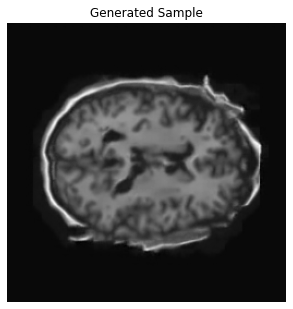

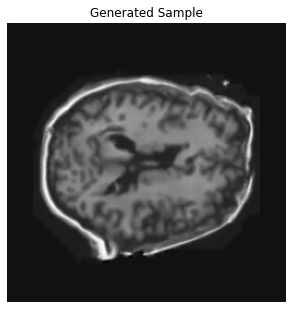

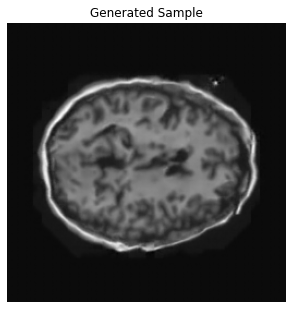

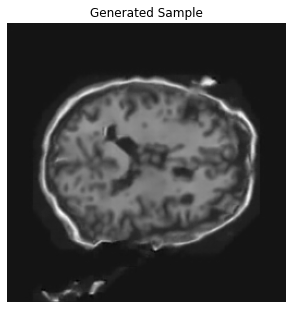

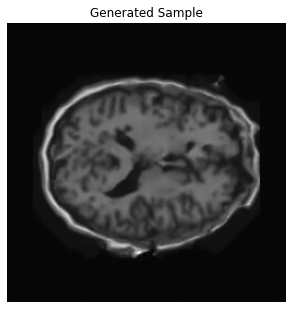

In [20]:
# Generate images.
decoder = vqvae_trainer.decoder
generated_samples = decoder.predict(quantized)
figs =  ['fig1.png','fig2.png','fig3.png','fig4.png','fig5.png']
for i in range(batch):
    plt.figure(figsize = (5,6))
    plt.imshow(generated_samples[i],cmap = 'gray')
    plt.title("Generated Sample")
    plt.axis("off")
    plt.show()
    im = keras.utils.array_to_img(generated_samples[i])
    im.save(figs[i])